In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import scipy.special as ss
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
#from catboost import Pool, CatBoostClassifier
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

In [3]:
# import a few basic models
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # not used here
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.externals import joblib
#from xgboost import XGBClassifier
import time

In [4]:
datapath = "/Users/ye/Documents/Code/bank/"
df = pd.read_csv(datapath + "accepted_2007_to_2018Q4.csv.gz", compression='gzip',low_memory=False,
                parse_dates=['issue_d'], infer_datetime_format=True)

In [5]:
#notes = pd.read_excel('LCDataDictionary.xlsx',sheet_name='browseNotes')
#notes.head()
# not really used, checked via spreadsheet directly

In [6]:
#dfeature = df.columns.values
#print(dfeature)

In [5]:
dfupto17 = df[(df.issue_d < '2018-01-01 00:00:00')] #loan issued upto 2017
#dfupto16 = df[(df.issue_d < '2017-01-01 00:00:00')] #loan issued upto 2016
#dftest = df[(df.issue_d >= '2017-01-01 00:00:00') & (df.issue_d < '2018-01-01 00:00:00')] #loan issued in 2017

In [6]:
print(df.shape, dfupto17.shape)
#(2260701, 151) (1765426, 151)

(2260701, 151) (1765426, 151)


In [ ]:
#======================================

In [7]:
dfupto17.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

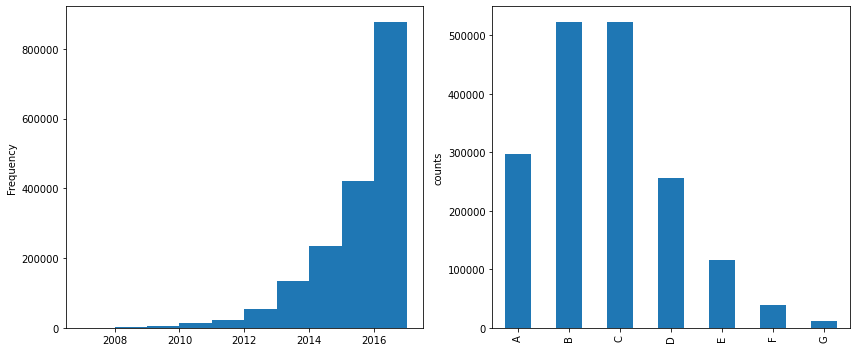

In [8]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
dfupto17.issue_d.dt.year.plot.hist()
fig.add_subplot(122)
dfupto17.grade.value_counts().sort_index().plot.bar()
plt.ylabel('counts')
plt.savefig('issuedloans.eps', format='eps')
plt.tight_layout()

In [9]:
dfupto17['loan_status'].value_counts()

Fully Paid                                             1029307
Current                                                 451136
Charged Off                                             259692
Late (31-120 days)                                       14246
In Grace Period                                           5517
Late (16-30 days)                                         2746
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     33
Name: loan_status, dtype: int64

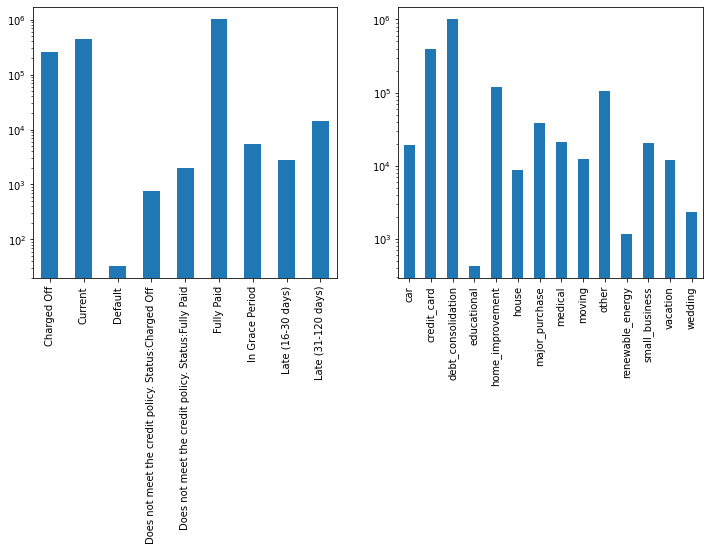

In [10]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
(dfupto17['loan_status'].value_counts().sort_index()).plot.bar(ax=ax1)
plt.yscale('log')
ax2 = fig.add_subplot(122)
(dfupto17['purpose'].value_counts().sort_index()).plot.bar(ax=ax2)
plt.yscale('log')
plt.savefig('loaninfo.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


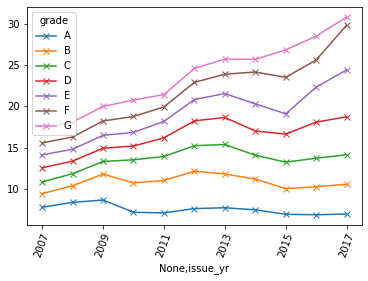

In [14]:
dftmp = dfupto17.copy()
dftmp['issue_yr'] = dftmp.issue_d.dt.year
rate = pd.pivot_table(dftmp[dftmp['term'] == ' 36 months'],index=["grade","issue_yr"],values=["int_rate"], aggfunc=np.mean)
g = rate.unstack().T.plot(marker='x')
g = g.set_xticklabels(np.arange(2005,2018,2), rotation=70)
plt.savefig('intR_grade.eps',format='eps')
# int rate seems to correlate with grade as expected

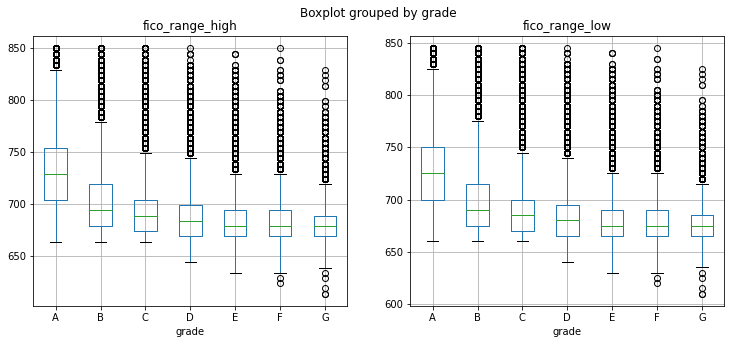

In [15]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
dfupto17.boxplot(by = 'grade', column = 'fico_range_high',ax=ax1)
ax2 = fig.add_subplot(122)
dfupto17.boxplot(by = 'grade', column = 'fico_range_low',ax=ax2)

# assume lender would look at relatively bad grade or high fico, but the plots
# below show for both ends of fico scores, each grade got similar issued loans

In [9]:
# start to reduce features on the data set that we do model

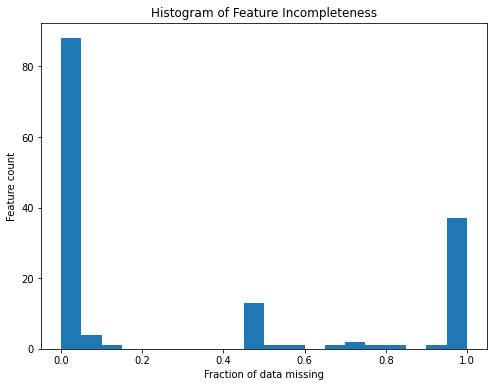

In [16]:
missing_fractions = dfupto17.isnull().mean().sort_values(ascending=False)
missing_fractions.head(12)
plt.figure(figsize=(8,6))
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')
plt.savefig('missingfrac.eps', format='eps')

In [17]:
drop_list1 = sorted(list(missing_fractions[missing_fractions > 0.3].index))
drop_list2 = sorted(list(missing_fractions[missing_fractions > 0.4].index))
drop_list3 = sorted(list(missing_fractions[missing_fractions > 0.5].index))
print(len(drop_list1), len(drop_list2), len(drop_list3))
# number of features dropped
# usually 30% could be the threshold, we will simply run with 40%

58 58 45


In [18]:
dfupto17.drop(labels=drop_list1, axis=1, inplace=True)
dfupto17.shape

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1765426, 93)

In [19]:
dfupto17.select_dtypes('object').columns

Index(['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d',
       'application_type', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')

In [20]:
dfupto17['emp_length'].unique()

array(['10+ years', '3 years', '4 years', '6 years', '1 year', '7 years',
       '8 years', '5 years', '2 years', '9 years', '< 1 year', nan],
      dtype=object)

In [21]:
# manually adjust a few easy-recognizable features' type
# earliest_cr_line --> time
# emp_length --> float
# id --> float
dfupto17['earliest_cr_line'] = pd.to_datetime(dfupto17['earliest_cr_line'], infer_datetime_format=True)
#dfupto16['sec_app_earliest_cr_line'] = pd.to_datetime(dfupto16['sec_app_earliest_cr_line'], infer_datetime_format=True)
dfupto17['emp_length'] = dfupto17['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
dfupto17['emp_length'] = dfupto17['emp_length'].str.extract('(\d+)').astype('float')
dfupto17['id'] = dfupto17['id'].astype('float')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [22]:
#nan_mean = dfupto17.isna().mean()
#nan_mean = nan_mean[nan_mean != 0].sort_values()
#nan_mean
# further check missing values? ref. P. Fesenko's code
# equiv to the code above for missing fraction

In [23]:
dfupto17.select_dtypes('number').columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_ac

In [24]:
# multicolinearity

In [25]:
num_feat = dfupto17.select_dtypes('number').columns.values

In [26]:
dfupto17[num_feat].nunique().sort_values()

policy_code               1
num_tl_30dpd              5
num_tl_120dpd_2m          7
acc_now_delinq            9
emp_length               11
                     ...   
total_rec_int        622189
last_pymnt_amnt      668807
total_pymnt_inv     1170608
total_pymnt         1453594
id                  1765426
Length: 71, dtype: int64

In [27]:
# further drop 'policy_code' which only has one value, and 'num_tl_30dpd', 'num_tl_120dpd_2m'
#dfupto17 = dfupto17.drop(['policy_code','num_tl_120dpd_2m', 'num_tl_30dpd'], axis=1, errors='ignore')
dfupto17 = dfupto17.drop(['policy_code'], axis=1, errors='ignore')

In [28]:
num_feat1 = dfupto17.select_dtypes('number').columns.values

In [29]:
corrM = dfupto17[num_feat1].fillna(0).corr()

In [183]:
#f = plt.figure(figsize=(19, 15))
#plt.matshow(corrM, fignum=f.number)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)

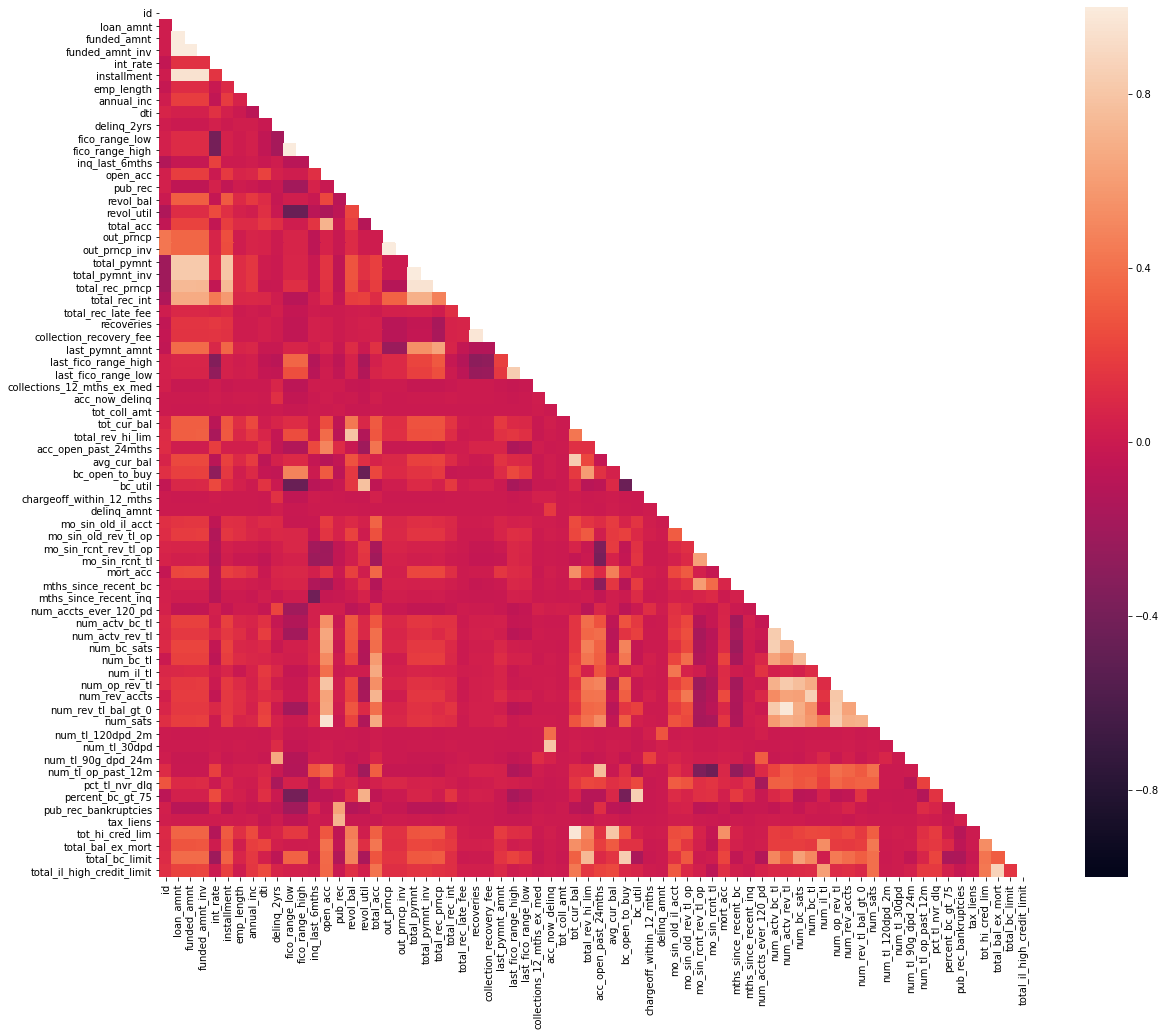

In [30]:
mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(corrM, mask=mask, square=True, vmin=-1, vmax=1, annot=False, fmt='.2f',ax=ax);

In [31]:
dfupto17.shape
#(1765426,92)

(1765426, 92)

In [ ]:
# further drop loan_amnt, funded_amnt_inv, installment, total_bal_ex_mort, tot_cur_bal, bc_util, open_acc

In [27]:
# start modeling attempt, df2017 is used as out of sample test

In [32]:
#num_feat = X.select_dtypes('number').columns.values;  num_feat1
data = dfupto17.copy()
comb_num_feat = np.array(list(combinations(num_feat1, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(data[comb[0]], data[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.8]
high_corr_num

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


array([['loan_amnt', 'funded_amnt'],
       ['loan_amnt', 'funded_amnt_inv'],
       ['loan_amnt', 'installment'],
       ['loan_amnt', 'total_pymnt'],
       ['loan_amnt', 'total_pymnt_inv'],
       ['funded_amnt', 'funded_amnt_inv'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'total_pymnt'],
       ['funded_amnt', 'total_pymnt_inv'],
       ['funded_amnt_inv', 'installment'],
       ['funded_amnt_inv', 'total_pymnt'],
       ['funded_amnt_inv', 'total_pymnt_inv'],
       ['installment', 'total_pymnt'],
       ['installment', 'total_pymnt_inv'],
       ['fico_range_low', 'fico_range_high'],
       ['out_prncp', 'out_prncp_inv'],
       ['total_pymnt', 'total_pymnt_inv'],
       ['total_pymnt', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_rec_prncp'],
       ['recoveries', 'collection_recovery_fee'],
       ['last_fico_range_high', 'last_fico_range_low']], dtype='<U26')

In [33]:
np.unique(high_corr_num[:, 0])

array(['fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'last_fico_range_high', 'loan_amnt', 'out_prncp', 'recoveries',
       'total_pymnt', 'total_pymnt_inv'], dtype='<U26')

In [34]:
data = data.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

In [35]:
data.shape
#(1765426, 82)

(1765426, 82)

In [36]:
data.columns.sort_values()

Index(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc',
       'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs',
       'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line',
       'emp_length', 'emp_title', 'fico_range_high', 'grade', 'hardship_flag',
       'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths',
       'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_low',
       'last_pymnt_amnt', 'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'n

In [41]:
# now there are 80 features left and there are a few obvious correlted ones that we need to drop (some of them are categorical):
#  grade:sub_grade, addr_state:zip_code, application_type: verification_status
data = data.drop(['sub_grade','addr_state','application_type'],axis=1)
print(data.shape)
#(1765426, 79)

(1765426, 79)


In [42]:
dfupto16 = data[(data.issue_d < '2017-01-01 00:00:00')] 
df2017 = data[(data.issue_d >= '2017-01-01 00:00:00') & (data.issue_d < '2018-01-01 00:00:00')] 
# issued at 2017

In [43]:
dfupto16.shape

(1321847, 79)

In [44]:
#print(data.shape)
del data

In [45]:
data = dfupto16.copy()
data.shape
# corr>0.9  (1321847, 82)
# corr>0.75  (1321847, 80)

(1321847, 79)

In [46]:
df2017.shape
# (443579, 79)

(443579, 79)

In [ ]:
# prepare for modelling

In [47]:
#data1 = data.loc[data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
# consider fully paid and current being good loans
data1 = data.loc[data['loan_status'].isin(['Fully Paid','Current','Charged Off'])]

In [48]:
data1['loan_status'].value_counts()

Fully Paid     899155
Charged Off    220544
Current        189285
Name: loan_status, dtype: int64

In [49]:
# modeling approach 
# target  loan status
#y = data['loan_status'].copy()
y = data1['loan_status'].copy()

In [50]:
y.unique()

array(['Fully Paid', 'Current', 'Charged Off'], dtype=object)

In [280]:
#y1.unique()

In [281]:
# we tried to predict good and bad (not necessarily charged off): this could be a multiclass classification
# we can focus on predicting: this is binary classification 

In [51]:
y = y.isin(['Current', 'Fully Paid']).astype('int')   
#y = y.isin(['Fully Paid']).astype('int')
y.value_counts()

1    1088440
0     220544
Name: loan_status, dtype: int64

In [283]:
#data.to_csv('model_data.csv')

In [52]:
#X_mod = data1[data1.grade.isin(['D','E','F','G'])].copy()  # only focus on low grade loans?
X_mod = data1.copy()
X_mod = X_mod.drop(['int_rate','id'], axis=1, errors='ignore')
#X_mod = X_mod.drop(['id'], axis=1, errors='ignore')
# as these are correlated with targets
X_mod = X_mod.dropna()  # gives recall 0.999?
#X_mod = X_mod.fillna(0)  # gives recall 1?
y_mod = y[X_mod.index]

In [53]:
X_mod = X_mod.drop('loan_status',axis=1)

In [54]:
X_mod.shape
# (951440, 76)

(951440, 76)

In [55]:
X_mod.columns

Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'url',
       'purpose', 'title', 'zip_code', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 

In [56]:
X_modlr = X_mod.copy()
X_modlr.shape
# (951440, 76)

(951440, 76)

In [57]:
# logistic regression try
model_LR = LogisticRegression()

In [58]:
X_modlr.select_dtypes('object').columns

Index(['term', 'grade', 'emp_title', 'home_ownership', 'verification_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

In [59]:
from sklearn.preprocessing import LabelEncoder
#dummydata = pd.get_dummies(X_modlr[cat_features_names],sparse=True)
#.apply(LabelEncoder().fit_transform)

In [120]:
X_modlr2 = X_modlr.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(X_modlr.select_dtypes(include=['number']))

In [121]:
X_trainlr, X_testlr, y_trainlr, y_testlr = train_test_split(X_modlr2, y_mod, test_size=0.33)

In [122]:
model_LR.fit(X_trainlr, y_trainlr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy (test): 0.956
Precision (test): 0.964
Recall (test): 0.983


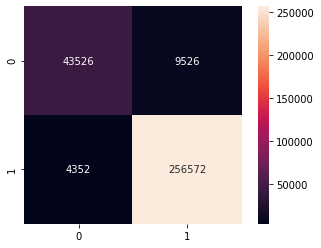

In [123]:
pred_LR = model_LR.predict(X_testlr)

acc_testlr = accuracy_score(y_testlr, pred_LR)
prec_testlr = precision_score(y_testlr, pred_LR)
rec_testlr = recall_score(y_testlr, pred_LR)
print(f'''Accuracy (test): {acc_testlr:.3f}
Precision (test): {prec_testlr:.3f}
Recall (test): {rec_testlr:.3f}''')

cm = confusion_matrix(y_testlr, pred_LR)
sns.heatmap(cm, annot=True, fmt='d', square=True)
#ax1.set_xlabel('Predicted')
#ax1.set_ylabel('True');
plt.savefig('confusM_lr.eps', format='eps')  # 95.1% accuracy,  96.2% precision

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


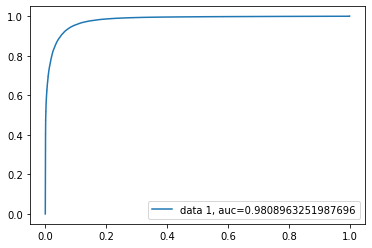

In [124]:
y_pred_proba = model_LR.predict_proba(X_testlr)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_testlr,  y_pred_proba)
auc = metrics.roc_auc_score(y_testlr, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
#plt.show()
plt.savefig('lr_auc.eps', format='eps')

In [65]:
#feat = model_LR.feature_names_
coeff = model_LR.coef_
#coeff.reshape(len(coeff.T),1)
#imp = model_LR.feature_importances_
coef = pd.DataFrame(coeff.reshape(len(coeff.T),1), X_testlr.columns, columns=['coef'])
#model_LR.coef_.T.
#X_testlr.columns.shape

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


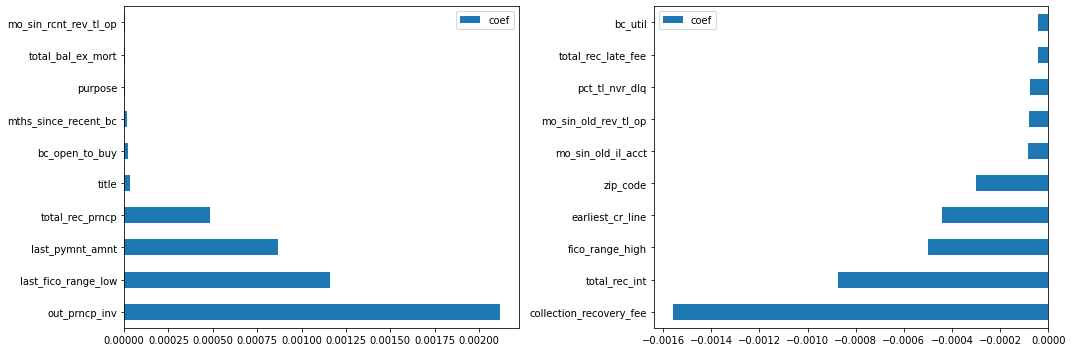

In [66]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
coef.sort_values(by=['coef'],ascending=False)[:10].plot(kind = "barh",ax=ax1)
ax2 = fig.add_subplot(122)
coef.sort_values(by=['coef'],ascending=True)[:10].plot(kind = "barh",ax=ax2)
plt.tight_layout()
plt.savefig('logitfeat.eps', format='eps')

In [118]:
X_testlr.columns

Index(['term', 'grade', 'emp_title', 'home_ownership', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_sinc

In [ ]:
##---------------------------2017 issued loan test ------------------------------------------------

Current        261851
Fully Paid     130152
Charged Off     39148
Name: loan_status, dtype: int64
(322161,) (322161, 76)
Accuracy (test): 0.990
Precision (test): 0.992
Recall (test): 0.996


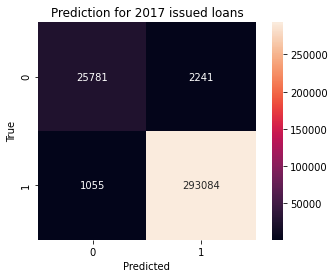

In [68]:
# to predict 2017 loan, need new pooltest
datatest = df2017.loc[df2017['loan_status'].isin(['Fully Paid', 'Current','Charged Off'])]
print(datatest['loan_status'].value_counts())

yt = datatest['loan_status'].copy()
yt = yt.isin(['Fully Paid','Current']).astype('int')
xtest =datatest.copy()
xtest = xtest.drop(['int_rate','loan_status','id'], axis=1, errors='ignore')
xtest1 = xtest.dropna()
xtest = xtest1.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(xtest1.select_dtypes(include=['number']))
ytest = yt[xtest.index]
#cat_f = xtest.select_dtypes('object').columns # here we specify names of categorical features
#cat_f_ind = [xtest.columns.get_loc(col) for col in cat_f]
#print(cat_f_ind)
#pool_test2017 = Pool(xtest, ytest, cat_features=cat_f_ind)

y_pred_17 = model_LR.predict(xtest)

print(y_pred_17.shape, xtest.shape)

acc_test17 = accuracy_score(ytest, y_pred_17)
prec_test17 = precision_score(ytest, y_pred_17)
rec_test17 = recall_score(ytest, y_pred_17)
print(f'''Accuracy (test): {acc_test17:.3f}
Precision (test): {prec_test17:.3f}
Recall (test): {rec_test17:.3f}''')

cm = confusion_matrix(ytest, y_pred_17)
ax = sns.heatmap(cm, annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');
ax.set_title('Prediction for 2017 issued loans')
plt.savefig('logit_outsample.eps', format='eps')

In [ ]:
##---------------------------2017 issued loan ------------------------------------------------

In [ ]:
##--------------------------- logistic case study (only manually select a few features like some study in Kaggle) ------------------------------------------------

In [70]:
# logistic regression attempt with manually selected finite features
dflrtry = dfupto17[['loan_amnt','term','int_rate','installment','emp_length','home_ownership','revol_bal','revol_util',
                   'fico_range_low','inq_last_6mths','last_pymnt_amnt','annual_inc','open_acc','dti','delinq_2yrs','loan_status']]
dflrtry = dflrtry.loc[dflrtry['loan_status'].isin(['Fully Paid','Current', 'Charged Off'])]

In [71]:
num_feat0 = dflrtry.select_dtypes('number').columns.values
corrM0 = dflrtry[num_feat0].fillna(0).corr()

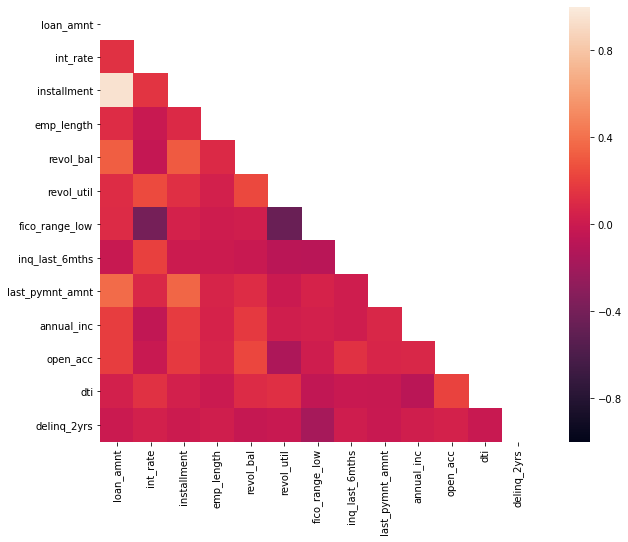

In [72]:
mask = np.zeros_like(corrM0)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corrM0, mask=mask, square=True, vmin=-1, vmax=1, annot=False, fmt='.2f',ax=ax);

In [73]:
dflrtry=dflrtry.drop(['installment'],axis=1)

In [74]:
X_modlr0 = dflrtry.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(dflrtry.select_dtypes(include=['number']))
X_modlr0 = X_modlr0.dropna()

In [75]:
y = dflrtry['loan_status'].copy()

In [76]:
y.unique()

array(['Fully Paid', 'Current', 'Charged Off'], dtype=object)

In [77]:
y = y.isin(['Fully Paid','Current']).astype('int')
y.value_counts()

1    1480443
0     259692
Name: loan_status, dtype: int64

In [78]:
X_modlr0.columns

Index(['term', 'home_ownership', 'loan_status', 'loan_amnt', 'int_rate',
       'emp_length', 'revol_bal', 'revol_util', 'fico_range_low',
       'inq_last_6mths', 'last_pymnt_amnt', 'annual_inc', 'open_acc', 'dti',
       'delinq_2yrs'],
      dtype='object')

In [79]:
#X_modlr0=X_modlr0.drop(['loan_status'],axis=1)
y_mod0 = y[X_modlr0.index]

In [162]:
#X_modlr0 = X_modlr0.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(X_modlr0.select_dtypes(include=['number']))

In [80]:
X_trainlr0, X_testlr0, y_trainlr0, y_testlr0 = train_test_split(X_modlr0, y_mod0, test_size=0.33)

In [81]:
model_LR.fit(X_trainlr0, y_trainlr0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy (test): 0.867
Precision (test): 0.875
Recall (test): 0.985


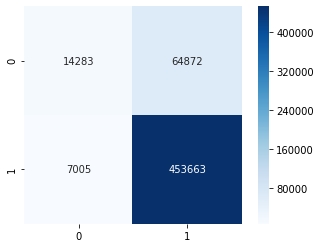

In [82]:
pred_LR0 = model_LR.predict(X_testlr0)

acc_testlr0 = accuracy_score(y_testlr0, pred_LR0)
prec_testlr0 = precision_score(y_testlr0, pred_LR0)
rec_testlr0 = recall_score(y_testlr0, pred_LR0)
print(f'''Accuracy (test): {acc_testlr0:.3f}
Precision (test): {prec_testlr0:.3f}
Recall (test): {rec_testlr0:.3f}''')

cm0 = confusion_matrix(y_testlr0, pred_LR0)
sns.heatmap(cm0, annot=True, cmap='Blues', fmt='d', square=True)
#Accuracy (test): 0.867
#Precision (test): 0.875
#Recall (test): 0.985

In [ ]:
##--------------------------- logistic case study ------------------------------------------------

In [83]:
##--------------------------- Catboost model ------------------------------------------------
from catboost import Pool, CatBoostClassifier
X_mod.shape, y_mod.shape
#((951440, 76), (951440,))

((951440, 76), (951440,))

In [84]:
# start with X_mod
X_modcat = X_mod.copy()
y_modcat = y_mod.copy()
X_traincat, X_testcat, y_traincat, y_testcat = train_test_split(X_modcat, y_modcat, stratify=y_modcat, random_state=0)
X_traincat, X_valcat, y_traincat, y_valcat = train_test_split(X_traincat, y_traincat, stratify=y_traincat, random_state=0)

In [85]:
cat_features_names = X_modcat.select_dtypes('object').columns # here we specify names of categorical features
cat_feat_ind = [X_modcat.columns.get_loc(col) for col in cat_features_names]
print(cat_feat_ind)
#[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 23, 29, 31, 73, 74, 75]

[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 23, 29, 31, 73, 74, 75]


In [86]:
pool_train = Pool(X_traincat, y_traincat, cat_features=cat_feat_ind)
pool_val = Pool(X_valcat, y_valcat, cat_features=cat_feat_ind)
pool_test = Pool(X_testcat, y_testcat, cat_features=cat_feat_ind)

n = y_traincat.value_counts()

In [87]:
model = CatBoostClassifier(learning_rate=0.05,
                           iterations=800,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy (test): 0.998
Precision (test): 0.999
Recall (test): 0.999


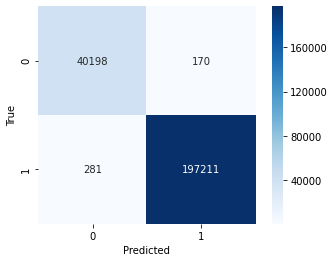

In [88]:
y_pred_testcat = model.predict(pool_test)

acc_test_cat = accuracy_score(y_testcat, y_pred_testcat)
prec_test_cat = precision_score(y_testcat, y_pred_testcat)
rec_test_cat = recall_score(y_testcat, y_pred_testcat)
print(f'''Accuracy (test): {acc_test_cat:.3f}
Precision (test): {prec_test_cat:.3f}
Recall (test): {rec_test_cat:.3f}''')

cmcat = confusion_matrix(y_testcat, y_pred_testcat)
ax = sns.heatmap(cmcat, annot=True, cmap='Blues', fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');
plt.savefig('confuM_cat.eps', format='eps')

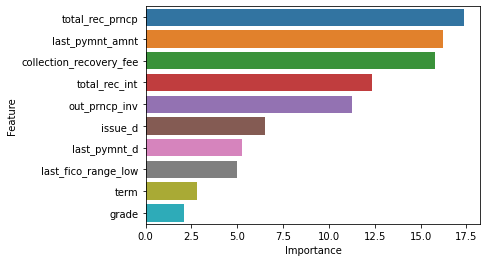

In [89]:
feat = model.feature_names_
imp = model.feature_importances_
dff = pd.DataFrame({'Feature': feat, 'Importance': imp})
dff = dff.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=dff);
plt.savefig('ImportantF_cat.eps', format='eps')

In [90]:
datatest.shape, df2017.shape
((431151, 79), (443579, 79))

((431151, 79), (443579, 79))

In [91]:
# to predict 2017 loan, need new pooltest
#datatest = df2017.loc[df2017['loan_status'].isin(['Fully Paid', 'Current','Charged Off'])]
#datatest['loan_status'].value_counts()
#yt = datatest['loan_status'].copy()
#yt = yt.isin(['Fully Paid']).astype('int')
xtest = datatest.copy()
#xtest = xtest.drop(['int_rate','loan_status','id'], axis=1, errors='ignore')
xtest= xtest.dropna()
#xtest = xtest1.select_dtypes(exclude=['number']).apply(LabelEncoder().fit_transform).join(xtest1.select_dtypes(include=['number']))
ytest = yt[xtest.index]
cat_f = xtest.select_dtypes('object').columns # here we specify names of categorical features
cat_f_ind = [xtest.columns.get_loc(col) for col in cat_f]
print(cat_f_ind)
pool_test2017 = Pool(xtest, ytest, cat_features=cat_f_ind)

y_pred_17 = model.predict(pool_test2017)

print(y_pred_17.shape, xtest.shape)


[1, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15, 26, 32, 34, 76, 77, 78]
(322161,) (322161, 79)


Accuracy (test): 1.000
Precision (test): 1.000
Recall (test): 1.000


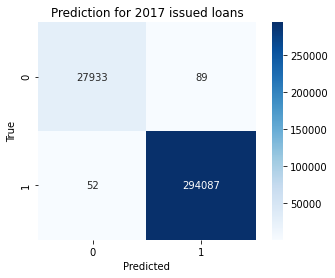

In [92]:
acc_test17 = accuracy_score(ytest, y_pred_17)
prec_test17 = precision_score(ytest, y_pred_17)
rec_test17 = recall_score(ytest, y_pred_17)
print(f'''Accuracy (test): {acc_test17:.3f}
Precision (test): {prec_test17:.3f}
Recall (test): {rec_test17:.3f}''')

cm = confusion_matrix(ytest, y_pred_17)
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');
ax.set_title('Prediction for 2017 issued loans')
plt.savefig('confuM_17testcat.eps', format='eps')

In [93]:
#feat

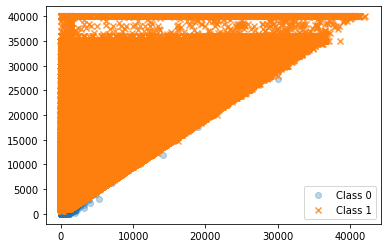

In [95]:
# try scatter plot for labels 0, 1
cond0 = data1['loan_status'].isin(['Charged Off'])
cond1 = data1['loan_status'].isin(['Fully Paid','Current'])
fig, ax = plt.subplots()
ax.scatter(data1[cond0]['last_pymnt_amnt'],data1[cond0]['total_rec_prncp'],label='Class 0',alpha=0.3,marker='o')
ax.scatter(data1[cond1]['last_pymnt_amnt'],data1[cond1]['total_rec_prncp'],label='Class 1',alpha=0.8,marker='x')
ax.legend()
#ax.set(yscale="log")

In [ ]:
# simple neural nets using pymc3 (only trial version)

In [96]:
#  neural network
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
from sklearn.preprocessing import scale

In [97]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X_nn.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.

        ann_input = pm.Data('ann_input', X_trainnn)
        ann_output = pm.Data('ann_output', y_trainnn)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X_nn.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=y_trainnn.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

In [98]:
X_nn = X_modlr2.copy()
X_trainnn, X_testnn, y_trainnn, y_testnn = train_test_split(X_nn, y_mod, test_size=0.33, random_state=0)

In [99]:
neural_network = construct_nn(X_trainnn, y_trainnn)

In [107]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)
    
#for 5000 iterations
#CPU times: user 58min 28s, sys: 17min 3s, total: 1h 15min 31s
#Wall time: 40min 53s

Average Loss = 3.1448e+05: 100%|██████████| 10000/10000 [1:22:01<00:00,  2.11it/s]
Finished [100%]: Average Loss = 3.1448e+05


CPU times: user 1h 55min 35s, sys: 34min 14s, total: 2h 29min 50s
Wall time: 1h 22min 4s


In [108]:
# draw samples 
trace = approx.sample(draws=5000)

In [109]:
# get predicted probability from model
#neural_network.out.distribution.p

In [110]:
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_trainnn[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)


In [114]:
pred = sample_proba(X_testnn, 1000).mean(0) > 0.75
# Use probability of > 0.75 to assume prediction of class 1
print('Accuracy = {}%'.format((y_testnn == pred).mean() * 100))

Accuracy = 83.0006115117079%


In [116]:
pred = sample_proba(X_testnn, 1000).mean(0) > 0.5
# Use probability of > 0.5 to assume prediction of class 1
print('Accuracy = {}%'.format((y_testnn == pred).mean() * 100))

Accuracy = 83.06908808316558%


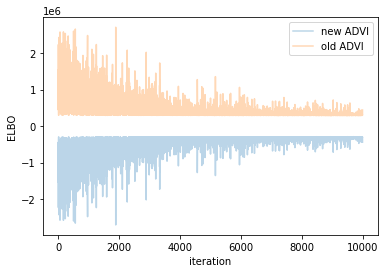

In [113]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration'); # convergence, ELBO is the objective function